In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import requests
from os.path import split,join,splitext,exists
import nibabel as nib
from scipy.stats import norm

In [2]:
image_url = 'https://download.brainlib.org/hackathon/2022_GYBS/input/lightsheet/subject/subject2_25.nii.gz'
image_url = 'https://download.brainlib.org/hackathon/2022_GYBS/input/fMOST/subject/196471_red_mm_SLA.nii.gz'
image_fname = split(image_url)[-1]

In [3]:
if not exists(image_fname):
    r = requests.get(image_url,stream=True)
    with open(image_fname,'wb') as f:
        for chunk in r.iter_content(chunk_size=1024):
            f.write(chunk)

In [4]:
print(image_fname)

196471_red_mm_SLA.nii.gz


In [5]:
vol = nib.load(image_fname)

In [6]:
I = vol.get_fdata()
dI = np.array(vol.header['pixdim'][1:4]).astype(float)
nI = np.array(I.shape)
xI = [np.arange(n)*d for n,d in zip(nI,dI)]

In [7]:
def draw3d(I,xI=None,n_slices=5,fig=None,vmin=None,vmax=None,**kwargs):
    '''Draw a 3D image, note components are on the last axis'''
    if fig is None:
        fig = plt.figure()
    else:
        fig.clf()
    ax = []
    ax_ = []
    
    # vmin and vmax
    # potentially could be a list for each channel
    if vmin is None:
        vmin = np.min(I)
    if vmax is None:
        vmax = np.max(I)
        
    # we will normalize
    I = I - vmin # I think this should make a copy
    I /= vmax-vmin
    
    # first index constant
    for axis in range(3):        
        # need extent
        slices = np.round(np.linspace(0,I.shape[axis]-1,n_slices+2)[1:-1]).astype(int)
        for i,s in enumerate(slices):
            ax__ = fig.add_subplot(3,n_slices,i+1+axis*n_slices)
            ax__.imshow(np.take(I,s,axis=axis),vmin=0.0,vmax=1.0,**kwargs)
            
            ax_.append(ax__)
        ax.append(ax_)
    
    return fig,ax
    
    


In [8]:
#draw3d(I,xI,cmap='gray')    

In [9]:
# set up a filter
# TODO: account for nonuniform sampling
r=1
x = np.arange(-r,r+1)
X = np.stack(np.meshgrid(x,x,x,indexing='ij'))
k = np.exp(-np.sum(X**2,0)/2.0)
k /= np.sum(k)

In [10]:
k.shape

(3, 3, 3)

In [11]:
# set up a morlet with 3 directions
l=3.0
wave = np.exp(2.0*np.pi*1j/l*X)
wavelet = wave*k[...,None]
# make zero mean
wavelet = k[...,None] * (wave - np.sum(wavelet,(0,1,2)))
# add just a smoothing and concatenate
wavelet = np.concatenate((k[...,None],wavelet),-1)

In [12]:
def downsample(I,labels,n_scatter,n_init=0,n_final=0,max_scatter=2):
    '''
    This downsampling multiplies by all wavelets at once
    This may be too much memory
    Below I am separating red and green and blue channels
    '''
    print(f'Initial I shape {I.shape}')
    # initial downsampling (e.g. for debugging)
    for i in range(n_init):
        nd = np.array(I.shape)//2
        I = I[0:nd[0]*2:2]*0.5 + I[1:nd[0]*2:2]*0.5
        I = I[:,0:nd[1]*2:2]*0.5 + I[:,1:nd[1]*2:2]*0.5
        I = I[:,:,0:nd[2]*2:2]*0.5 + I[:,:,1:nd[2]*2:2]*0.5
        # update labels here
        labels = [ l + str(0) for l in labels] 
        print(f'Initial downsampled I, size is {I.shape}')
    
    slice0 = slice(None,-2,None)
    slice1 = slice(1,-1,None)
    slice2 = slice(2,None,None)
    slices = [slice0,slice1,slice2]
    for _ in range(n_scatter):
        for i in range(3):
            for j in range(3):
                for k in range(3):
                    if i==0 and j==0 and k==0:
                        I_ = I[slices[i],slices[j],slices[k],None,:]*wavelet[i,j,k,:,None]
                    else:
                        I_ += I[slices[i],slices[j],slices[k],None,:]*wavelet[i,j,k,:,None]

        # the None's are as above so they will reshape properly
        # take absolute value and reshape it
        I_ = np.abs(I_.reshape(I_.shape[0],I_.shape[1],I_.shape[2],-1))

        # downsample
        nd = np.array(I_.shape)//2
        I_ = I_[0:nd[0]*2:2]*0.5 + I_[1:nd[0]*2:2]*0.5
        I_ = I_[:,0:nd[1]*2:2]*0.5 + I_[:,1:nd[1]*2:2]*0.5
        I_ = I_[:,:,0:nd[2]*2:2]*0.5 + I_[:,:,1:nd[2]*2:2]*0.5

        # labels
        labels_ = [ l + str(i) for i in range(4) for l in labels] 
        
        # reset references to working variables
        I = I_
        labels = labels_


        # filter out paths that are too long (have too many nonlinearities)
        # note it would be better to just not calculate them, but this is a minor performance hit
        lengths = [len([t for t in l if t=='1' or t=='2' or t=='3' ]) for l in labels]        
        inds = [l<=max_scatter for l in lengths]                   
        I = I[...,inds]
        labels = [l for l,i in zip(labels,inds) if i]
        print(f'Filtered I, shape is {I.shape}')
    
    # now final downsampling
    for i in range(n_final):
        nd = np.array(I.shape)//2
        I = I[0:nd[0]*2:2]*0.5 + I[1:nd[0]*2:2]*0.5
        I = I[:,0:nd[1]*2:2]*0.5 + I[:,1:nd[1]*2:2]*0.5     
        I = I[:,:,0:nd[2]*2:2]*0.5 + I[:,:,1:nd[2]*2:2]*0.5     
        # update labels here
        labels = [ l + str(0) for l in labels] 
        print(f'Final downsampled I, size is {I.shape}')
    return I,labels
    

In [13]:
Id,labels = downsample(I[...,None],labels=[''],n_scatter=3,n_init=0,n_final=0)

Initial I shape (767, 1078, 1109, 1)
Filtered I, shape is (382, 538, 553, 4)
Filtered I, shape is (190, 268, 275, 16)
Filtered I, shape is (94, 133, 136, 37)


In [14]:
# now we need to take the pca and view it
def pca(I,w=None,output_v=False):
    if w is None:
        w = np.ones((I.shape[0],I.shape[1],I.shape[2]))
    
    w = w.reshape(-1)[...,None]
    ws = np.sum(w)
    Iv = np.reshape(I,(I.shape[0]*I.shape[1]*I.shape[2],-1))
    Ivbar = np.sum(Iv*w,0,keepdims=True)/ws
    Iv0 = Iv - Ivbar
    S = (Iv0.T@(Iv0*w))/ws # divide by number of pixels
    w_,v = np.linalg.eigh(S)
    s = np.sqrt(w_)
    Ip = (Iv0@v).reshape(I.shape)
    
    
    if output_v:
        return Ip[...,::-1],s[::-1],v[:,::-1]
    # put in decreasing order and return
    return Ip[...,::-1],s[::-1]
def pca_scale(Ip,s):    
    return norm.cdf(Ip/s[None,None])

<IPython.core.display.Javascript object>


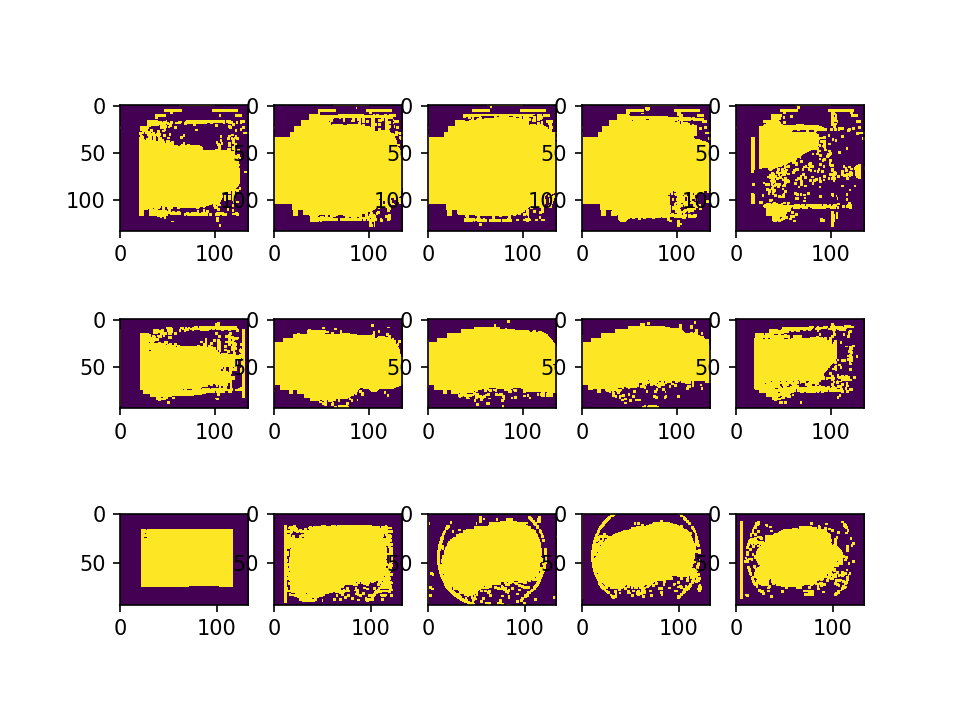

(<Figure size 640x480 with 15 Axes>,
 [[<matplotlib.axes._subplots.AxesSubplot at 0x7f6bc6bf61d0>,
   <matplotlib.axes._subplots.AxesSubplot at 0x7f6bc6904550>]])

In [30]:
w = 1.0 - (Id[...,0]==0)
draw3d(w)

In [31]:
Ip,s = pca(Id,w)
Is = pca_scale(Ip,s)

<IPython.core.display.Javascript object>


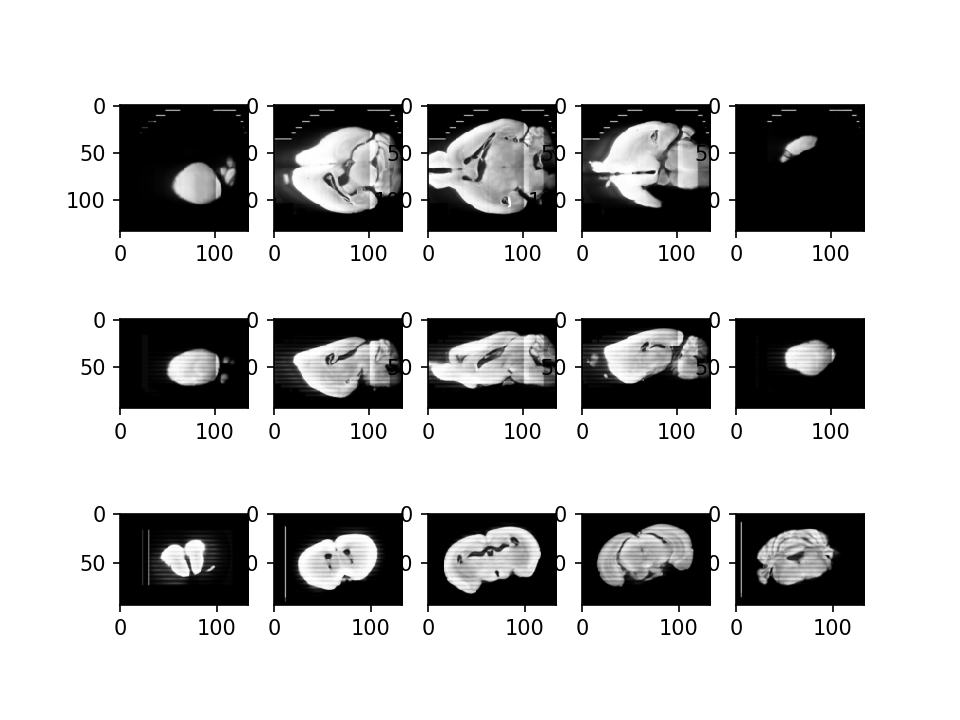

<IPython.core.display.Javascript object>


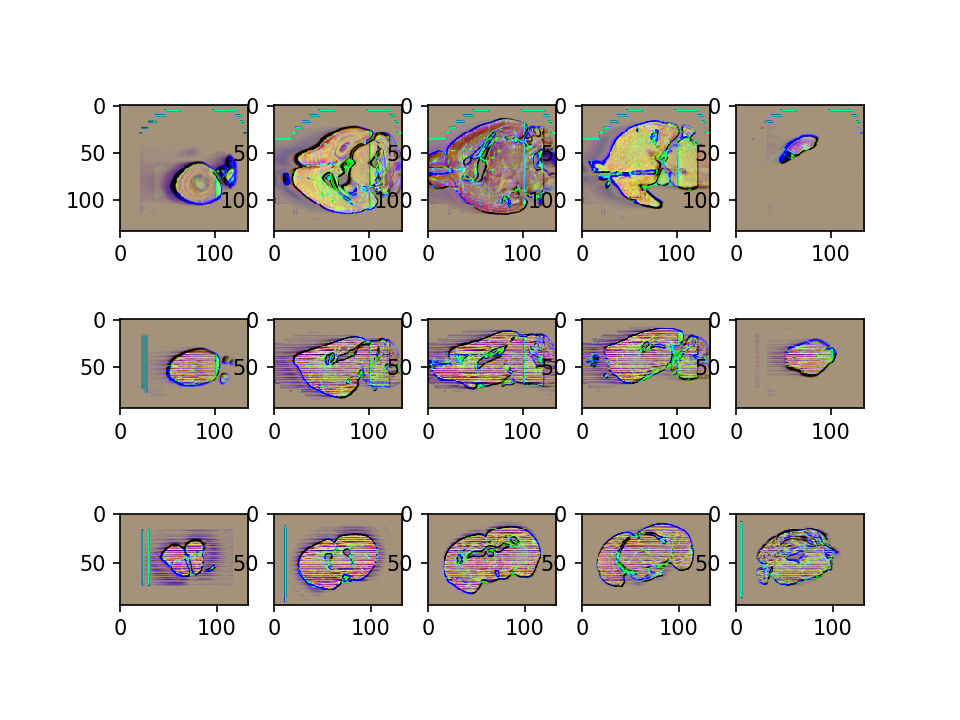

In [32]:
fig,ax = draw3d(Is[...,0],cmap='gray')
fig,ax = draw3d(Is[...,1:4])

In [17]:
# now we want to combine based on labels
# any pair of two different directions at different scales can be rotated into one another
# so all we need to consider is same versus different


In [18]:
Ir = []
labelsr = []
done = np.array([False for _ in labels])
for i in range(len(labels)):
    if done[i]:
        continue
    
    length = np.sum([l!='0' for l in labels[i]])
    
    if length == 0:
        Ir.append(Id[...,i])
        labelsr.append(labels[i])
    elif length == 1:
        # in this case they are all equivalent if they are at the same scale
        ind = np.where([l!='0' for l in labels[i]])[0][0]
        inds = []
        # find all the labels that are nonzero in this spot
        for j in range(len(labels)):
            if done[j]:
                continue
            length_ = np.sum([l!='0' for l in labels[j]])
            if length_==1 and labels[j][ind]!='0':
                inds.append(j)
        Ir.append(np.mean(Id[...,inds],-1))
        labelsr.append(labels[i])
        done[inds] = True
    elif length == 2:
        #print(f'Found length 2 sequence {labels[i]}')
        # there are two cases now the two are the same, or the two are different
        ind0,ind1 = np.where([l!='0' for l in labels[i]])[0][:2]
        # is it the same or different
        same = labels[i][ind0]==labels[i][ind1]
        inds = []
        for j in range(len(labels)):
            if done[j]:
                continue
            length_ = np.sum([l!='0' for l in labels[j]])
            if length_==2:
                ind0_,ind1_ = np.where([l!='0' for l in labels[j]])[0][:2]
                same_ = labels[j][ind0_]==labels[j][ind1_]
                if ind0==ind0_ and ind1==ind1_ and same==same_:
                    inds.append(j)
                    #print(f'Found matching length 2 sequence {labels[j]}')
        Ir.append(np.mean(Id[...,inds],-1))
        labelsr.append(labels[i])
        done[inds] = True
                
    
    done[i] = True
Ir = np.stack(Ir,-1)

<IPython.core.display.Javascript object>


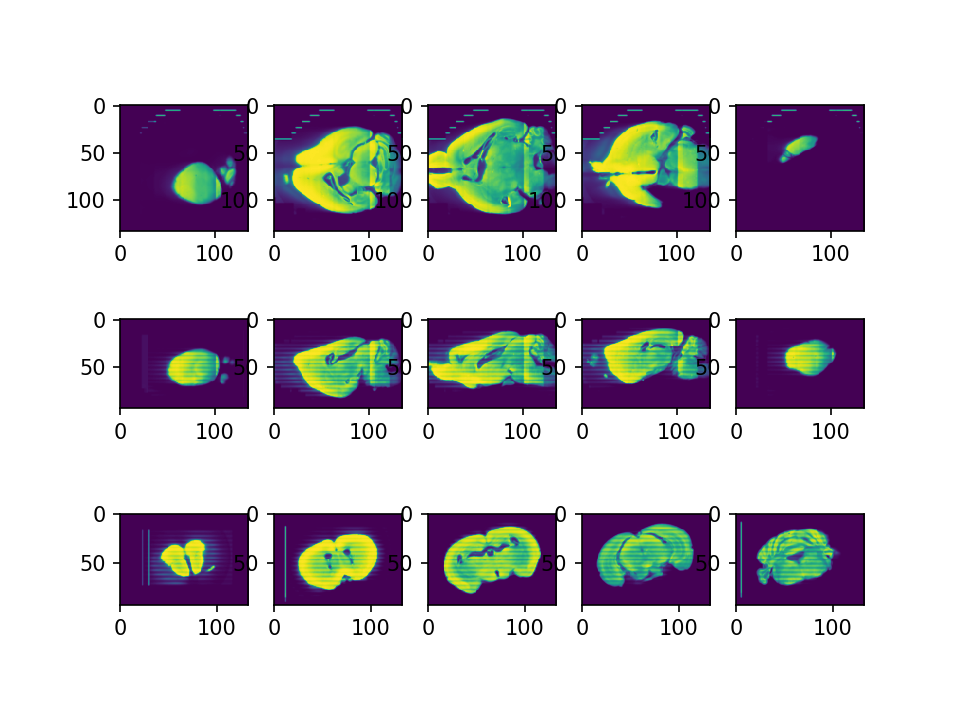

<IPython.core.display.Javascript object>


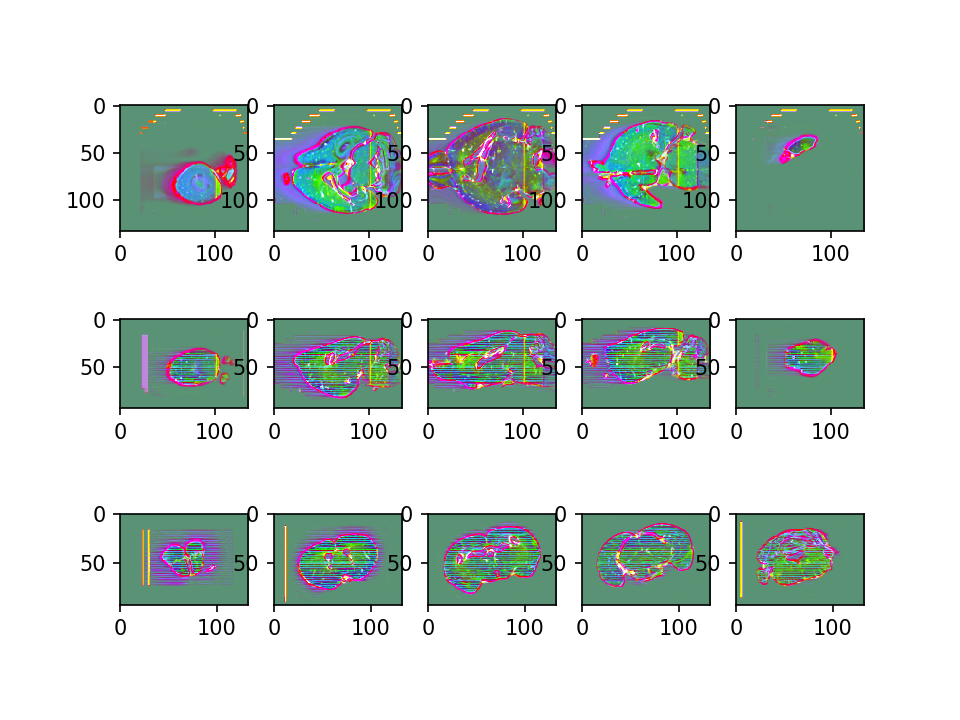

<IPython.core.display.Javascript object>


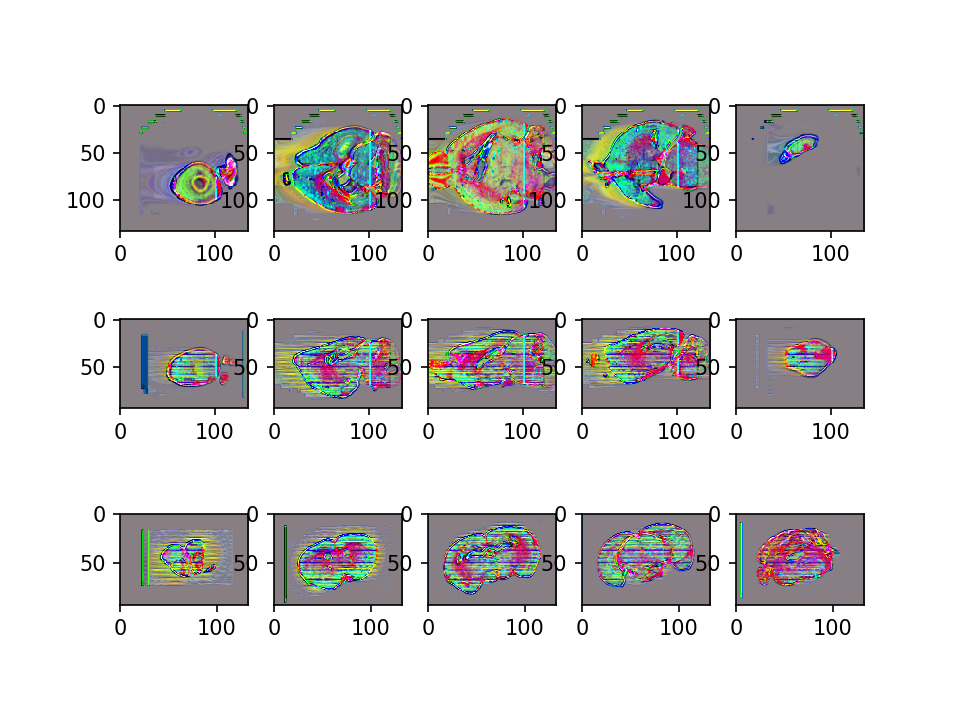

In [42]:
Ip,s = pca(Ir,w)
Is = pca_scale(Ip,s)
fig,ax = draw3d(Is[...,0])
fig,ax = draw3d(Is[...,1:4])
fig,ax = draw3d(Is[...,4:7])
